In [3]:
!pip install efficientnet_pytorch==0.7.1
!pip install librosa==0.6.0
!pip install numba==0.48.0 --user

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [22]:
# import datetime
from datetime import datetime, timedelta, timezone
datetime.now(timezone(timedelta(hours=8)))

datetime.datetime(2021, 7, 15, 0, 22, 57, 308197, tzinfo=datetime.timezone(datetime.timedelta(0, 28800)))

In [ ]:
MODEL_PATH = 's3://sagemaker-us-west-2-355444812467/model'
model_data_s3_uri = f'{MODEL_PATH}/model_0715_0.tar.gz'
!aws s3 cp model.tar.gz $model_data_s3_uri

In [4]:
MODEL_PATH = 's3://sagemaker-us-west-2-355444812467/model'
model_data_s3_uri = f'{MODEL_PATH}/model_0715_liyu.tar.gz'
!aws s3 cp ./model/model_0715_liyu.tar.gz $model_data_s3_uri

upload: model/model_0715_liyu.tar.gz to s3://sagemaker-us-west-2-355444812467/model/model_0715_liyu.tar.gz


In [16]:
datetime.tzinfo()

In [91]:
!nvidia-smi

Wed Jul 14 09:24:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   59C    P0    58W / 149W |   2445MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Base Package
import os
import time
import copy
import datetime
from pprint import pformat
import logging
import numpy as np
import pandas as pd 
from tqdm import tqdm_notebook
import tqdm
import json
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet

# Our Package
from dataset import SoundDataset, get_melspec
from models import ModelEMA 
from metrics import roc_auc 
from ops import AdamW

In [80]:
meta_train = pd.read_csv('../Final_Training_Dataset/meta_train.csv')
meta_train

,Filename,Label,Remark
0,train_00001,0,Barking
1,train_00002,0,Barking
2,train_00003,0,Barking
3,train_00004,0,Barking
4,train_00005,0,Barking
...,...,...,...
1595,train_01596,9,Laugh_Shout_Scream
1596,train_01597,9,Laugh_Shout_Scream
1597,train_01598,9,Laugh_Shout_Scream
1598,train_01599,9,Laugh_Shout_Scream


In [81]:
# 參數設定
device = "cuda" if torch.cuda.is_available() else "cpu"
use_ema = True

save_model_dir = 'eff_class10_0714'
if not os.path.isdir(f'./model/{save_model_dir}'):
    os.mkdir(f'./model/{save_model_dir}')

train_record = {}
for i in ['accuracy', 'loss', 'auc']:
    for j in range(5):
        train_record[f'valid_{i}_{j}'] = []

# if not os.path.exists('params.save_root'):
#     os.mkdir(params.save_root)
#     print("create folder: {}".format(params.save_root))
#     if not os.path.exists(os.path.join(params.save_root, 'snapshots')):
#         os.mkdir(os.path.join(params.save_root, 'snapshots'))
#     if not os.path.exists(os.path.join(params.save_root, 'log')):
#         os.mkdir(os.path.join(params.save_root, 'log'))

####################################
# data preparing & model training  #
####################################

# 訓練資料集
# train_sepc = []
# for file_name in tqdm.notebook.tqdm(meta_train.Filename):
#     train_sepc.append(get_melspec('train_data',file_name))
# train_sepc   

In [20]:
train_sepc = []
for file_name in tqdm.notebook.tqdm(meta_train.Filename):
    train_sepc.append(get_melspec('Final_Training_Dataset/train/',file_name))
train_sepc  

  0%|          | 0/1600 [00:00<?, ?it/s]

Final_Training_Dataset/train/ train_01046


[array([[-17.09003175, -14.01200846, -12.18023501, ..., -50.43101376,
         -50.43101376, -50.43101376],
        [-25.39133119, -24.54552613, -19.20814406, ..., -50.43101376,
         -50.43101376, -50.43101376],
        [-24.98745803, -24.76602971, -24.27314717, ..., -50.43101376,
         -50.43101376, -50.43101376],
        ...,
        [-50.43101376, -50.43101376, -50.43101376, ..., -50.43101376,
         -50.43101376, -50.43101376],
        [-50.43101376, -50.43101376, -50.43101376, ..., -50.43101376,
         -50.43101376, -50.43101376],
        [-50.43101376, -50.43101376, -50.43101376, ..., -50.43101376,
         -50.43101376, -50.43101376]]),
 array([[-33.80788651, -33.9563355 , -33.71291439, ..., -48.19989802,
         -48.19989802, -48.19989802],
        [-48.19989802, -48.19989802, -48.19989802, ..., -48.19989802,
         -48.19989802, -48.19989802],
        [-48.19989802, -48.19989802, -48.19989802, ..., -48.19989802,
         -48.19989802, -48.19989802],
        ...,


In [19]:
!unzip /Final_Training_Dataset/train.zip

unzip:  cannot find or open /Final_Training_Dataset/train.zip, /Final_Training_Dataset/train.zip.zip or /Final_Training_Dataset/train.zip.ZIP.


In [89]:
# 儲存資料(npy格式)
# np.save('./train_spec_class10_0711.npy', np.array(train_sepc))
# 讀取資料(npy格式)
train_sepc = np.load('../train_spec_class10_0711.npy')
train_sepc

array([[[-17.09003175, -14.01200846, -12.18023501, ..., -50.43101376,
         -50.43101376, -50.43101376],
        [-25.39133119, -24.54552613, -19.20814406, ..., -50.43101376,
         -50.43101376, -50.43101376],
        [-24.98745803, -24.76602971, -24.27314717, ..., -50.43101376,
         -50.43101376, -50.43101376],
        ...,
        [-50.43101376, -50.43101376, -50.43101376, ..., -50.43101376,
         -50.43101376, -50.43101376],
        [-50.43101376, -50.43101376, -50.43101376, ..., -50.43101376,
         -50.43101376, -50.43101376],
        [-50.43101376, -50.43101376, -50.43101376, ..., -50.43101376,
         -50.43101376, -50.43101376]],

       [[-33.80788651, -33.9563355 , -33.71291439, ..., -48.19989802,
         -48.19989802, -48.19989802],
        [-48.19989802, -48.19989802, -48.19989802, ..., -48.19989802,
         -48.19989802, -48.19989802],
        [-48.19989802, -48.19989802, -48.19989802, ..., -48.19989802,
         -48.19989802, -48.19989802],
        ...,


In [8]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10,in_channels=3).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/ec2-user/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [92]:
trn_dataset = SoundDataset(np.array(train_sepc), meta_train.Label.values)

trn_loader = DataLoader(trn_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [12]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
for fold, (train_index, val_index) in enumerate(skf.split(train_sepc, meta_train.Label.values)):
    if fold > 0:
        break
    

In [13]:
class DogDataset(Dataset):
    def __init__(self, spec):
        self.specs = spec
        
    def __len__(self):
        return len(self.specs)
    
    def __getitem__(self, item):
        mel_spec = self.specs[item]
        mel_spec = np.stack((mel_spec, mel_spec, mel_spec))/255
        return mel_spec, 0

In [12]:
# test_set = DogDataset(np.array(train_sepc))
test_set = SoundDataset(np.array(train_sepc),  meta_train.Label.values)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
for batch in tqdm_notebook(test_loader):
    imgs, labels = batch
images = imgs.to(device, dtype=torch.float)
labels = labels.to(device)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10,in_channels=3).to(device)
model.load_state_dict(torch.load('./model/eff_class10_0711/model_auc_0.9999218750000001.pth'))
model.eval()


Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [34]:
imgs[0][:][:].shape

torch.Size([3, 128, 157])

In [21]:
img_test = imgs[0][:][:]

# 

In [44]:
mel_concat.shape

(3, 128, 157)

In [49]:
img_test.shape

(1, 3, 128, 157)

In [68]:
# 製作頻譜圖
def get_melspec(prefix, file_name):
    y, sr = librosa.load(f'{prefix}/{file_name}.wav', sr = 8000)
    if len(y)<sr*5:
        print(prefix,file_name)
        l = sr*5-len(y)
        y = np.hstack([y,np.zeros(l)])
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y, sr=sr, n_mels=128, n_fft=1024, hop_length=256))
    return mel_spec

In [94]:
%time

# 讀取資料
mel_spec = get_melspec('Final_Training_Dataset/train/', 'train_00001')
mel_concat = np.stack((mel_spec, mel_spec, mel_spec)) / 255

# 轉格式
img_test = np.reshape(mel_concat, (1, mel_concat.shape[0], mel_concat.shape[1], mel_concat.shape[2]))
wav = torch.tensor(img_test) 

# 模型輸入
model_input = wav.to(device, dtype=torch.float)
outputs = model(model_input)
outputs = torch.nn.functional.softmax(outputs, dim=1)
_, preds = torch.max(outputs, 1)

# Request
pred_label = preds.cpu().detach().numpy()
outputs = outputs.cpu().detach().numpy()

print(pred_label, outputs)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs


FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/SageMaker/incremental_training_tbrain_dog/01-byoc/code/Final_Training_Dataset/train/train_00001.wav'

In [ ]:
1+1

In [4]:
# import soundfile as sf
def wav_read(wav_file): 
    wav_data, sr = librosa.load(wav_file, sr = 8000)
    return wav_data, sr

def inference_single_audio(path): 
    wav_data, sr = wav_read(path)
    return wav_data, sr

In [21]:
# wav,sr = inference_single_audio(path)
# wav = preprocessing(params, wav, sr)




You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [ ]:
def preprocessing(params, wav_data, sr):
    """Convert wav_data to log mel spectrogram.
        1. normalize the wav_data
        2. convert the wav_data into mono-channel
        3. resample the wav_data to the sampling rate we want
        4. compute the log mel spetrogram with librosa function
    Args:
        wav_data: An np.array indicating wav data in np.int16 datatype
        sr: An integer specifying the sampling rate of this wav data
    Return:
        inpt: An np.array indicating the log mel spectrogram of data
    """
    # transform samples to mel spectrogram
    inpt_x = 500
    inpt = np.reshape(spec_db, (1, spec_db.shape[0], spec_db.shape[1]))

    return inpt.astype('float32')

In [205]:
pd.DataFrame(labels).value_counts()

4    9
7    8
2    8
0    8
5    7
3    7
1    7
9    4
8    3
6    3
dtype: int64

In [206]:
y_true = np.eye(10)[np.hstack(labels.numpy())]
y_score = np.vstack(nn.Softmax(dim=-1)(logits[:, :10]).to('cpu').detach().numpy())

In [207]:
valid_auc = roc_auc(y_true, y_score)

In [209]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os

def plot_confusion_matrix(cm, target_names, folder_name,
                          title='Confusion matrix', cmap=None,
                          normalize=False):
    """Plot confustion matrix
        Save the confusion matrix as png file
    Args:
        cm ([[int]]): confusion matrix
        target_names ([str]): the label name of each class
        folder_name (str): filename of png file
        title (str)(optinal): the title name on png file
        cmap (cmap_type)(optional): the type of cmap
        normalize (bool)(optional): show the figure as percentage
    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'
               .format(accuracy, misclass))
    plt.savefig(os.path.join(folder_name, "cfm.png"))

In [196]:
# np.eye(10)[list(np.hstack(val_label))]
np.vstack(val_pred_p).shape

(320, 10)

In [216]:
logits.argmax(dim=-1).to('cpu').numpy()

array([4, 7, 0, 2, 6, 0, 8, 9, 2, 4, 5, 6, 7, 2, 8, 0, 3, 2, 1, 1, 2, 6,
       2, 2, 1, 3, 3, 7, 3, 5, 1, 7, 0, 7, 7, 5, 2, 5, 9, 7, 4, 4, 0, 4,
       8, 5, 1, 5, 5, 4, 3, 3, 4, 9, 4, 4, 1, 7, 0, 3, 1, 0, 9, 0])

In [217]:
cm = pd.crosstab(labels.numpy(), logits.argmax(dim=-1).to('cpu').numpy())
cm

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,8,0,0,0,0,0,0,0,0,0
1,0,7,0,0,0,0,0,0,0,0
2,0,0,8,0,0,0,0,0,0,0
3,0,0,0,7,0,0,0,0,0,0
4,0,0,0,0,9,0,0,0,0,0
5,0,0,0,0,0,7,0,0,0,0
6,0,0,0,0,0,0,3,0,0,0
7,0,0,0,0,0,0,0,8,0,0
8,0,0,0,0,0,0,0,0,3,0


In [190]:
roc_auc(np.eye(10)[list(np.hstack(val_label))],np.vstack(val_pred_p))

0.9997224702380955

In [90]:
# 5-fold 
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=321)
for fold, (train_index, val_index) in enumerate(skf.split(train_sepc, meta_train.Label.values)):
    
#     if fold > 0:
#         break
    print(f'---- fold{fold} --------------------------------------')

    print("Preparing training/validation data...")
    trn_dataset = SoundDataset(np.array(train_sepc)[train_index], meta_train.Label.values[train_index])
    val_dataset = SoundDataset(np.array(train_sepc)[val_index], meta_train.Label.values[val_index], mode='val')
    # num_workers：使用多進程加載的進程數、pin_memory：是否將數據保存在pin memory區，pin memory中的數據轉到GPU會快一些
    trn_loader = DataLoader(trn_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    print("Preparing efficientnet model...")
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10,in_channels=3).to(device)
#     model.load_state_dict(torch.load('./model/eff_class10_0711/model_auc_fold_0.ckpt'))
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  
    
    print("Preparing model path...")
    best_loss = 10; best_acc = 0.0; patience = 0; patience_total = 50; best_auc = 0.5    
    model_path = f'./model/{save_model_dir}/model_loss_fold_{fold}.ckpt'
    model_path_2 = f'./model/{save_model_dir}/model_acc_fold_{fold}.ckpt'
    model_path_3 = f'./model/{save_model_dir}/model_auc_fold_{fold}.ckpt'

    if use_ema:
        ema_model = ModelEMA(model, decay=0.99)
        
    print("Starting train model...")
    # ---- train -------------------------------------------------
    for epoch in range(0,1000):
        
        print(f"epoch: {epoch}...")
        # ---------- Training ----------
        model.train()
        train_loss = 0; reg_loss = 0; correct = 0; total = 0            

        # Iterate the training set by batches.
        # for batch in tqdm.notebook.tqdm(trn_loader):
        for batch in trn_loader:

            # ---------- mixup -----------
            inputs, targets = batch
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs = inputs.float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if use_ema:
                ema_model.update(model)

        # ---------- Validation ----------
        if use_ema:
            test_model = ema_model.ema
        else:
            test_model = model
        test_model.eval()

        # Validation 紀錄
        valid_loss = []; valid_accs = []; val_label = []; val_pred = []; val_pred_p = []
        # Iterate the validation set by batches.
        for batch in val_loader:

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # 驗證階段不用梯度的資訊，取消梯度以加速運算
            with torch.no_grad():
                logits = test_model(imgs.to(device).float())

            # 計算每批 loss 跟 accuracy
            loss = criterion(logits, labels.to(device))   
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean() 
            val_pred.append(logits.argmax(dim=-1).to('cpu').numpy())
            val_label.append(labels.numpy())
            val_pred_p.append(nn.Softmax(dim=-1)(logits[:,:10]).to('cpu').numpy())
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())

        # 計算整體 loss 跟 accuracy
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        cm = pd.crosstab(np.hstack(val_label),np.hstack(val_pred))
        # print(cm)roc_auc_score(y_true, y_score, multi_class=multi_class, average=average)
        valid_auc = roc_auc(np.eye(10)[list(np.hstack(val_label))],np.vstack(val_pred_p))

        train_record[f'valid_loss_{fold}'].append(valid_loss)
        train_record[f'valid_accuracy_{fold}'].append(valid_acc)
        train_record[f'valid_auc_{fold}'].append(valid_auc)

        if valid_auc > best_auc:
            print(f'the best valid auc score is {valid_auc} now.')
            best_auc = valid_auc
            torch.save(test_model.state_dict(), f'./model/{save_model_dir}/model_auc_{valid_auc}.pth')
#             torch.save(test_model.state_dict(), model_path_3)
            print(f'epoch_{epoch} ','saving model with auc {:.5f}'.format(valid_auc))
            patience=0
        else:
            # early stopping
            patience+=1
            if patience>patience_total:
                print(f'final auc score is {best_auc}, stopping training at {epoch} epoch.')
                break

---- fold0 --------------------------------------
Preparing training/validation data...
Preparing efficientnet model...
Loaded pretrained weights for efficientnet-b0
Preparing model path...
Starting train model...
epoch: 0...
the best valid auc score is 0.6464293154761905 now.
epoch_0  saving model with auc 0.64643
epoch: 1...
the best valid auc score is 0.7776391369047618 now.
epoch_1  saving model with auc 0.77764
epoch: 2...
the best valid auc score is 0.8837313988095238 now.
epoch_2  saving model with auc 0.88373
epoch: 3...
the best valid auc score is 0.9453705357142856 now.
epoch_3  saving model with auc 0.94537
epoch: 4...
the best valid auc score is 0.9629732142857144 now.
epoch_4  saving model with auc 0.96297
epoch: 5...
the best valid auc score is 0.9701793154761905 now.
epoch_5  saving model with auc 0.97018
epoch: 6...
the best valid auc score is 0.974625744047619 now.
epoch_6  saving model with auc 0.97463
epoch: 7...
the best valid auc score is 0.9812864583333335 now.
ep

the best valid auc score is 0.9964077380952381 now.
epoch_25  saving model with auc 0.99641
epoch: 26...
the best valid auc score is 0.9964873511904762 now.
epoch_26  saving model with auc 0.99649
epoch: 27...
the best valid auc score is 0.9967633928571429 now.
epoch_27  saving model with auc 0.99676
epoch: 28...
the best valid auc score is 0.9973325892857143 now.
epoch_28  saving model with auc 0.99733
epoch: 29...
epoch: 30...
epoch: 31...
epoch: 32...
epoch: 33...
epoch: 34...
epoch: 35...
epoch: 36...
epoch: 37...
epoch: 38...
epoch: 39...
epoch: 40...
epoch: 41...
epoch: 42...
epoch: 43...
epoch: 44...
epoch: 45...
epoch: 46...
epoch: 47...
epoch: 48...
epoch: 49...
epoch: 50...
epoch: 51...
epoch: 52...
epoch: 53...
epoch: 54...
epoch: 55...
epoch: 56...
epoch: 57...
epoch: 58...
epoch: 59...
epoch: 60...
epoch: 61...
epoch: 62...
epoch: 63...
epoch: 64...
epoch: 65...
epoch: 66...
epoch: 67...
epoch: 68...
epoch: 69...
epoch: 70...
epoch: 71...
epoch: 72...
epoch: 73...
epoch: 7

the best valid auc score is 0.996315217326934 now.
epoch_89  saving model with auc 0.99632
epoch: 90...
the best valid auc score is 0.9963598210356637 now.
epoch_90  saving model with auc 0.99636
epoch: 91...
epoch: 92...
epoch: 93...
epoch: 94...
epoch: 95...
epoch: 96...
epoch: 97...
epoch: 98...
epoch: 99...
epoch: 100...
epoch: 101...
epoch: 102...
epoch: 103...
epoch: 104...
epoch: 105...
epoch: 106...
epoch: 107...
epoch: 108...
epoch: 109...
epoch: 110...
epoch: 111...
epoch: 112...
epoch: 113...
epoch: 114...
epoch: 115...
epoch: 116...
epoch: 117...
epoch: 118...
epoch: 119...
epoch: 120...
epoch: 121...
epoch: 122...
epoch: 123...
epoch: 124...
epoch: 125...
epoch: 126...
epoch: 127...
epoch: 128...
epoch: 129...
epoch: 130...
epoch: 131...
epoch: 132...
epoch: 133...
epoch: 134...
epoch: 135...
epoch: 136...
epoch: 137...
epoch: 138...
epoch: 139...
epoch: 140...
epoch: 141...
final auc score is {best_auc}, stopping training at {epoch} epoch.


In [2]:
!df

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
Filesystem     1K-blocks      Used Available Use% Mounted on
devtmpfs        31426652        72  31426580   1% /dev
tmpfs           31437352     15164  31422188   1% /dev/shm
/dev/xvda1     108305356 108288972         0 100% /
/dev/xvdf      515535104  60288312 433189756  13% /home/ec2-user/SageMaker


<AxesSubplot:>

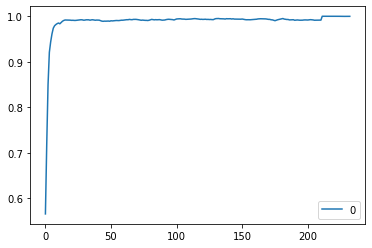

In [126]:
pd.DataFrame(train_record['valid_auc_0']).plot()

In [20]:
# Save valid score
filename = "valid_score.json"
with open(filename, "w") as file: 
    json.dump(train_record, file) 

In [23]:

def main():
#     parser = ArgumentParser()
#     # data or model path setting
#     parser.add_argument("--csv_path", type=str, default='/DATA/meta_train.csv', help='the path of train csv file')
#     parser.add_argument("--data_dir", type=str, default="/DATA/train", help="the directory of sound data")
#     # training parameter setting
#     parser.add_argument("--model_name", type=str, default='EFFb0', choices=['EFFb0'], help='the algorithm we used')
#     parser.add_argument("--val_split", type=float, default=0.1, help="the ratio of validation set. 0 means there's no validation dataset")
#     parser.add_argument("--epochs", type=int, default=20, help="epoch number")
#     parser.add_argument("--batch_size", type=int, default=32, help="batch size")
#     parser.add_argument("--optimizer", type=str, default="AdamW", choices=["AdamW"])
#     parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
#     parser.add_argument("--num_class", type=int, default=6, help="number of classes")
#     # data augmentation setting
#     parser.add_argument("--spec_aug", action='store_true', default=False)
#     parser.add_argument("--time_drop_width", type=int, default=64)
#     parser.add_argument("--time_stripes_num", type=int, default=2)
#     parser.add_argument("--freq_drop_width", type=int, default=8)
#     parser.add_argument("--freq_stripes_num", type=int, default=2)
#     # proprocessing setting
#     parser.add_argument("--sr", type=int, default=8000)
#     parser.add_argument("--nfft", type=int, default=200)
#     parser.add_argument("--hop", type=int, default=80)
#     parser.add_argument("--mel", type=int, default=64)
#     args = parser.parse_args()
#     logging.basicConfig(level=logging.INFO)
#     logger.info("Arguments: %s", pformat(args))

    ##################
    # config setting #
    ##################



#     # 5-fold 
#     skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=23)
#     for fold, (train_index, val_index) in enumerate(skf.split(train_sepc, meta_train.Label.values)):
        
#         if fold != 3:
#             continue
        
#         print(f'---- fold{fold} --------------------------------------')

#         print("Preparing training/validation data...")
#         trn_dataset = SoundDataset(np.array(train_sepc)[train_index], meta_train.Label.values[train_index])
#         val_dataset = SoundDataset(np.array(train_sepc)[val_index], meta_train.Label.values[val_index], mode='val')
#         # num_workers：使用多進程加載的進程數、pin_memory：是否將數據保存在pin memory區，pin memory中的數據轉到GPU會快一些
#         trn_loader = DataLoader(trn_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
#         val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

#         print("Preparing efficientnet model...")
#         model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=6,in_channels=3).to(device)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)    

#         best_loss = 10; best_acc = 0.0; patience = 0; patience_total = 150; best_auc = 0.5    
#         model_path = f'./model/{save_model_dir}/model_loss_fold_{fold}.ckpt'
#         model_path_2 = f'./model/{save_model_dir}/model_acc_fold_{fold}.ckpt'
#         model_path_3 = f'./model/{save_model_dir}/model_auc_fold_{fold}.ckpt'
        
#         if use_ema:
#             ema_model = ModelEMA(model, decay=0.99)

#         # ---- train -------------------------------------------------
#         for epoch in range(0,1000):

#             # ---------- Training ----------
#             model.train()
#             train_loss = 0; reg_loss = 0; correct = 0; total = 0            

#             # Iterate the training set by batches.
#             # for batch in tqdm.notebook.tqdm(trn_loader):
#             for batch in trn_loader:
            
#                 # ---------- mixup -----------
#                 inputs, targets = batch
#                 inputs, targets = inputs.cuda(), targets.cuda()
#                 inputs = inputs.float()
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 train_loss += loss.item()
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += targets.size(0)
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 if use_ema:
#                     ema_model.update(model)

#         # ---------- Validation ----------
#         if use_ema:
#             test_model = ema_model.ema
#         else:
#             test_model = model
#         test_model.eval()

#         # Validation 紀錄
#         valid_loss = []; valid_accs = []; val_label = []; val_pred = []; val_pred_p = []
#         # Iterate the validation set by batches.
#         for batch in val_loader:

#             # A batch consists of image data and corresponding labels.
#             imgs, labels = batch

#             # 驗證階段不用梯度的資訊，取消梯度以加速運算
#             with torch.no_grad():
#                 logits = test_model(imgs.to(device).float())

#             # 計算每批 loss 跟 accuracy
#             loss = criterion(logits, labels.to(device))   
#             acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean() 
#             val_pred.append(logits.argmax(dim=-1).to('cpu').numpy())
#             val_label.append(labels.numpy())
#             val_pred_p.append(nn.Softmax(dim=-1)(logits[:,:10]).to('cpu').numpy())
#             valid_loss.append(loss.item())
#             valid_accs.append(acc.item())

#         # 計算整體 loss 跟 accuracy
#         valid_loss = sum(valid_loss) / len(valid_loss)
#         valid_acc = sum(valid_accs) / len(valid_accs)
        
#         cm = pd.crosstab(np.hstack(val_label),np.hstack(val_pred))
#         # print(cm)roc_auc_score(y_true, y_score, multi_class=multi_class, average=average)
#         valid_auc = roc_auc(np.eye(6)[list(np.hstack(val_label))],np.vstack(val_pred_p))

#         train_record[f'valid_loss_{fold}'].append(valid_loss)
#         train_record[f'valid_accuracy_{fold}'].append(valid_acc)
#         train_record[f'valid_auc_{fold}'].append(valid_auc)
        
#         if valid_loss < best_loss:
#             best_loss = valid_loss
#             torch.save(test_model.state_dict(), model_path)
#             print(f'epoch_{epoch} ','saving model with loss {:.5f}'.format(valid_loss))
#             patience=0
#         else:
#             patience+=1
#             if patience>patience_total:
#                 print('loss')
#                 break
#         if valid_acc > best_acc:
#             best_acc = valid_acc
#             torch.save(test_model.state_dict(), model_path_2)
#             print(f'epoch_{epoch} ','saving model with accuracy {:.5f}'.format(valid_acc))
#             patience=0
#         else:
#             patience+=1
#             if patience>patience_total:
#                 print('acc')
#                 break  
#         if valid_auc > best_auc:
#             best_auc = valid_auc
#             torch.save(test_model.state_dict(), model_path_3)
#             print(f'epoch_{epoch} ','saving model with auc {:.5f}'.format(valid_auc))
#             patience=0
#         else:
#             patience+=1
#             if patience>patience_total:
#                 print('auc')
#                 break
    
#     # Save valid score
#     filename = "valid_score.json"
#     with open(filename, "w") as file: 
#         json.dump(train_record, file) 

#     ###################
#     # training ending #
#     ###################

# if __name__ == '__main__':
#     main()


---- fold3 --------------------------------------
Preparing training/validation data...
Preparing efficientnet model...
Loaded pretrained weights for efficientnet-b0


KeyboardInterrupt: 

In [69]:
def get_test_pred(model, test_loader):
    model.eval()
    test_pred = []
    for batch in tqdm_notebook(test_loader):

        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
        test_pred.append(nn.Softmax(dim=-1)(logits[:,:6]).to('cpu').numpy())

    test_pred = np.vstack(test_pred)
    return test_pred

In [65]:
a = f'./model/eff_0710/'
ckpt_list = [a+i for i in os.listdir(a) if '_fold' in i]
ckpt_list

['./model/eff_0710/model_auc_fold_1.ckpt',
 './model/eff_0710/model_acc_fold_0.ckpt',
 './model/eff_0710/model_loss_fold_2.ckpt',
 './model/eff_0710/model_auc_fold_0.ckpt',
 './model/eff_0710/model_acc_fold_3.ckpt',
 './model/eff_0710/model_loss_fold_0.ckpt',
 './model/eff_0710/model_loss_fold_3.ckpt',
 './model/eff_0710/model_acc_fold_4.ckpt',
 './model/eff_0710/model_loss_fold_1.ckpt',
 './model/eff_0710/model_acc_fold_1.ckpt',
 './model/eff_0710/model_auc_fold_4.ckpt',
 './model/eff_0710/model_auc_fold_2.ckpt',
 './model/eff_0710/model_loss_fold_4.ckpt',
 './model/eff_0710/model_auc_fold_3.ckpt',
 './model/eff_0710/model_acc_fold_2.ckpt']

In [66]:
all_pred = []
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=6,in_channels=3).to(device)

Loaded pretrained weights for efficientnet-b0


In [72]:
batch_size = 32; 

In [73]:

# all_pred.append(get_test_pred(model, test_loader))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/38 [00:00<?, ?it/s]

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ec2-user/SageMaker/incremental_training_tbrain_dog/01-byoc/code/dataset.py", line 110, in __getitem__
    return mel_spec, self.labels[idx]
TypeError: 'NoneType' object is not subscriptable


In [70]:
#!/usr/bin/env python

import os
import time
from tqdm import tqdm
import numpy as np
from argparse import ArgumentParser
from pprint import pformat
import pandas as pd
import logging

import torch
import librosa 
from torch.utils.data import DataLoader

from dataset import SoundDataset_test
import soundfile as sf
from config import ParameterSetting
from models import VGGish
from metrics import cfm, classification_report, roc_auc
import flask
import json 


logger = logging.getLogger(__file__)

app = flask.Flask("predict-server")
def run_predict_server():
    app.run(host='0.0.0.0', port=8080)


def wav_read(wav_file):
        wav_data, sr = sf.read(wav_file, dtype='int16')
        return wav_data, sr

def inference_single_audio(path): 
    wav_data, sr = wav_read(path)
    return wav_data, sr





def load_model(): 
    prefix = '/opt/ml/'
    model_name = "final_model.pkl"
    model_path = os.path.join(prefix, 'model', model_name)   
    model = None
    model = VGGish(params)
    model = torch.load(model_path)
    model.eval()
    model = model.to(device)
    return model 

@app.route('/ping', methods=['GET'])
def ping():
    """Determine if the container is working and healthy. In this sample container, we declare
    it healthy if we can load the model successfully."""
    status = 200 
    return flask.Response(response='\n', status=status, mimetype='application/json')



import uuid 
@app.route('/invocations', methods=['POST'])
def predict():
    data = flask.request.data
        
    path = '/tmp/{}.wav'.format(uuid.uuid4())
    tmpFile = open(path, 'wb')
    tmpFile.write(data)
    tmpFile.close()

    wav,sr = inference_single_audio(path)
    wav = preprocessing(params, wav, sr)
    wav = torch.tensor([wav])
    spec = wav.to(device)
    outputs = model(spec)
    outputs = torch.nn.functional.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)

    pred_label = preds.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    print(pred_label, outputs)
    results = {}
    results['label']=int(pred_label[0])
    results['probability']=outputs[0].tolist()
    return flask.Response(response=json.dumps(results), status=200, mimetype='text/json')


params = ParameterSetting(sr=8000,nfft=200, hop=80, mel=64, normalize=None, preload=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=load_model()
run_predict_server() 


ImportError: cannot import name 'SoundDataset_test'

In [52]:
# arn:aws:sagemaker:us-west-2:355444812467:endpoint/audio-1626195929
                    
api_endpoint = "https://runtime.sagemaker.us-west-2.amazonaws.com/endpoints/audio-1626195929/invocations"

!curl -X POST -H 'content-type: application/octet-stream' -H 'x-api-key: Y2hvdW44MTEzNjU6ZXJpYzA5MTYwNjY1NzU' --data-binary @../train_data/train_00002.wav    $api_endpoint                    

{"message":"Missing Authentication Token"}

In [76]:
import requests
import json

voice_data = '../train_data/train_00003.wav'
api_endpoint = "https://runtime.sagemaker.us-west-2.amazonaws.com/endpoints/audio-1626195929/invocations"

headers = {
    "Authorization": "Y2hvdW44MTEzNjU6ZXJpYzA5MTYwNjY1NzU",
    "Content-Type": "application/octet-stream",
}

r = requests.post(api_endpoint,
                  headers=headers, 
                  data=open(voice_data,'rb').read())

In [77]:
r

<Response [403]>

In [49]:
other_data_np_x = []
other_data_np_y = []
# root_other_dir = 
for i in range(10):
    root_other_dir = f'../other_data/category_0{i}/'
    all_npy = os.listdir(root_other_dir)
    if all_npy == []:
        continue
    data_temp = np.load(root_other_dir+np.random.choice(all_npy))
    rs = np.random.choice(data_temp.shape[1]-157)
    data_temp = data_temp[:,rs:rs+157]
    other_data_np_x.append(np.stack((data_temp, data_temp, data_temp))/255)
    other_data_np_y.append(i)
od_x = torch.tensor(np.r_[other_data_np_x])
od_y = torch.tensor(np.r_[other_data_np_y])

In [50]:
od_y

tensor([0, 1, 2, 4, 5, 6, 7, 9])

In [48]:
od

tensor([[[[-0.0431, -0.0446, -0.0450,  ..., -0.0415, -0.0425, -0.0431],
          [-0.0587, -0.0742, -0.0885,  ..., -0.0595, -0.0762, -0.0830],
          [-0.0838, -0.0845, -0.0877,  ..., -0.0828, -0.0891, -0.0799],
          ...,
          [-0.2161, -0.2109, -0.2175,  ..., -0.2014, -0.1868, -0.1671],
          [-0.2435, -0.2500, -0.2547,  ..., -0.2316, -0.2259, -0.2098],
          [-0.2591, -0.2591, -0.2591,  ..., -0.2591, -0.2591, -0.2591]],

         [[-0.0431, -0.0446, -0.0450,  ..., -0.0415, -0.0425, -0.0431],
          [-0.0587, -0.0742, -0.0885,  ..., -0.0595, -0.0762, -0.0830],
          [-0.0838, -0.0845, -0.0877,  ..., -0.0828, -0.0891, -0.0799],
          ...,
          [-0.2161, -0.2109, -0.2175,  ..., -0.2014, -0.1868, -0.1671],
          [-0.2435, -0.2500, -0.2547,  ..., -0.2316, -0.2259, -0.2098],
          [-0.2591, -0.2591, -0.2591,  ..., -0.2591, -0.2591, -0.2591]],

         [[-0.0431, -0.0446, -0.0450,  ..., -0.0415, -0.0425, -0.0431],
          [-0.0587, -0.0742, -

In [13]:
    root_other_dir = f'../other_data/category_0{i}/'
    all_npy = os.listdir(root_other_dir)
    np.random.choice(all_npy)

's01-240.npy'

In [40]:
np.random.choice(data_temp.shape[1]-157)

379